Introduction to Neural Networks Homework

In [1]:
%matplotlib inline

import torch
import torchvision
from torch import nn

import numpy
import matplotlib.pyplot as plt
import time

In [2]:
training_data = torchvision.datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=torchvision.transforms.ToTensor()
)

test_data = torchvision.datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=torchvision.transforms.ToTensor()
)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:00<00:00, 15.8MB/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 513kB/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 4.43MB/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 2.24MB/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [3]:
train_size = int(0.8 * len(training_data))  # 80% for training
val_size = len(training_data) - train_size  # Remaining 20% for validation
training_data, validation_data = torch.utils.data.random_split(training_data, [train_size, val_size], generator=torch.Generator().manual_seed(55))

In [4]:
print('MNIST data loaded: train:',len(training_data),' examples, validation: ', len(validation_data), 'examples, test:',len(test_data), 'examples')
print('Input shape', training_data[0][0].shape)

MNIST data loaded: train: 48000  examples, validation:  12000 examples, test: 10000 examples
Input shape torch.Size([1, 28, 28])


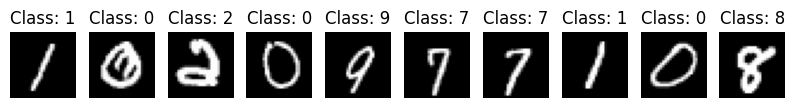

In [5]:
pltsize=1
plt.figure(figsize=(10*pltsize, pltsize))

for i in range(10):
    plt.subplot(1,10,i+1)
    plt.axis('off')
    plt.imshow(numpy.reshape(training_data[i][0], (28, 28)), cmap="gray")
    plt.title('Class: '+str(training_data[i][1]))

In [6]:
def train_one_epoch(dataloader, model, loss_fn, optimizer):
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # forward pass
        pred = model(X)
        loss = loss_fn(pred, y)

        # backward pass calculates gradients
        loss.backward()

        # take one step with these gradients
        optimizer.step()

        # resets the gradients
        optimizer.zero_grad()

In [7]:
def evaluate(dataloader, model, loss_fn):
    # Set the model to evaluation mode - some NN pieces behave differently during training
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    loss, correct = 0, 0

    # We can save computation and memory by not calculating gradients here - we aren't optimizing
    with torch.no_grad():
        # loop over all of the batches
        for X, y in dataloader:
            pred = model(X)
            loss += loss_fn(pred, y).item()
            # how many are correct in this batch? Tracking for accuracy
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    loss /= num_batches
    correct /= size

    accuracy = 100*correct
    return accuracy, loss

In [8]:
def show_failures(model, dataloader, maxtoshow=10):
    model.eval()
    batch = next(iter(dataloader))
    predictions = model(batch[0])

    rounded = predictions.argmax(1)
    errors = rounded!=batch[1]
    print('Showing max', maxtoshow, 'first failures. '
          'The predicted class is shown first and the correct class in parentheses.')
    ii = 0
    plt.figure(figsize=(maxtoshow, 1))
    for i in range(batch[0].shape[0]):
        if ii>=maxtoshow:
            break
        if errors[i]:
            plt.subplot(1, maxtoshow, ii+1)
            plt.axis('off')
            plt.imshow(batch[0][i,0,:,:], cmap="gray")
            plt.title("%d (%d)" % (rounded[i], batch[1][i]))
            ii = ii + 1

In [ ]:
%%time

epochs = 5
train_acc_all = []
val_acc_all = []
for j in range(epochs):
    train_one_epoch(train_dataloader, linear_model, loss_fn, optimizer)

    # checking on the training loss and accuracy once per epoch
    acc, loss = evaluate(train_dataloader, linear_model, loss_fn)
    train_acc_all.append(acc)
    print(f"Epoch {j}: training loss: {loss}, accuracy: {acc}")

    # checking on the validation loss and accuracy once per epoch
    val_acc, val_loss = evaluate(val_dataloader, linear_model, loss_fn)
    val_acc_all.append(val_acc)
    print(f"Epoch {j}: val. loss: {val_loss}, val. accuracy: {val_acc}")

In [ ]:
class NonlinearClassifier(nn.Module):

    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.layers_stack = nn.Sequential(
            nn.Linear(28*28, 50),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(50, 50),
            nn.ReLU(),
           # nn.Dropout(0.2),
            nn.Linear(50, 50),
            nn.ReLU(),
           # nn.Dropout(0.2),
            nn.Linear(50, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        x = self.layers_stack(x)

        return x

In [ ]:
%%time

epochs = 5
train_acc_all = []
val_acc_all = []
for j in range(epochs):
    train_one_epoch(train_dataloader, nonlinear_model, loss_fn, optimizer)

    # checking on the training loss and accuracy once per epoch
    acc, loss = evaluate(train_dataloader, nonlinear_model, loss_fn)
    train_acc_all.append(acc)
    print(f"Epoch {j}: training loss: {loss}, accuracy: {acc}")

    # checking on the validation loss and accuracy once per epoch
    val_acc, val_loss = evaluate(val_dataloader, nonlinear_model, loss_fn)
    val_acc_all.append(val_acc)
    print(f"Epoch {j}: val. loss: {val_loss}, val. accuracy: {val_acc}")

Showing max 10 first failures. The predicted class is shown first and the correct class in parentheses.


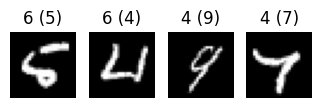

In [19]:
show_failures(nonlinear_model, test_dataloader)

# Homework

1. Compare the quality of your model when using different:
 - batch sizes,
 - learning rates,
 - activation functions.

3. Bonus: What is a learning rate scheduler?

If you have time, experiment with how to improve the model. Note: training and validation data can be used to compare models, but test data should be saved until the end as a final check of generalization.

In [10]:
learning_rates = [0.5, 0.1, 0.05]
batch_sizes = [32, 64, 128]
activation_functions = [nn.Tanh(), nn.GELU(), nn.LeakyReLU()]

results = []

for lr in learning_rates:
    for batch_size in batch_sizes:
        for activation in activation_functions:
            print(f"Training with lr={lr}, batch_size={batch_size}, activation={activation}")

            class NonlinearClassifier(nn.Module):
                def __init__(self, activation):
                    super().__init__()
                    self.flatten = nn.Flatten()
                    self.layers_stack = nn.Sequential(
                        nn.Linear(28*28, 50),
                        activation,
                        nn.Dropout(0.2),
                        nn.Linear(50, 50),
                        activation,
                        nn.Linear(50, 50),
                        activation,
                        nn.Linear(50, 10)
                    )

                def forward(self, x):
                    x = self.flatten(x)
                    x = self.layers_stack(x)
                    return x

            nonlinear_model = NonlinearClassifier(activation)
            loss_fn = nn.CrossEntropyLoss()
            optimizer = torch.optim.SGD(nonlinear_model.parameters(), lr=lr)
            train_dataloader = torch.utils.data.DataLoader(training_data, batch_size=batch_size)
            val_dataloader = torch.utils.data.DataLoader(validation_data, batch_size=batch_size)

            epochs = 5
            for j in range(epochs):
                train_one_epoch(train_dataloader, nonlinear_model, loss_fn, optimizer)
                acc, loss = evaluate(train_dataloader, nonlinear_model, loss_fn)
                print(f"Epoch {j}: training loss: {loss}, accuracy: {acc}")
                val_acc, val_loss = evaluate(val_dataloader, nonlinear_model, loss_fn)
                print(f"Epoch {j}: val. loss: {val_loss}, val. accuracy: {val_acc}")

            test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)
            acc_test, loss_test = evaluate(test_dataloader, nonlinear_model, loss_fn)
            results.append({
                'learning_rate': lr,
                'batch_size': batch_size,
                'activation': type(activation).__name__,
                'test_accuracy': acc_test,
                'test_loss': loss_test
            })
            print(f"Test Loss: {loss_test:.4f}, Test Accuracy: {acc_test:.2f}%")

Training with lr=0.5, batch_size=32, activation=Tanh()
Epoch 0: training loss: 0.1937920181105534, accuracy: 94.375
Epoch 0: val. loss: 0.19805535017947357, val. accuracy: 94.16666666666667
Epoch 1: training loss: 0.17049994785990566, accuracy: 95.07916666666667
Epoch 1: val. loss: 0.18355813001592955, val. accuracy: 94.475
Epoch 2: training loss: 0.15000949525708954, accuracy: 95.68541666666667
Epoch 2: val. loss: 0.17360344754283627, val. accuracy: 95.01666666666667
Epoch 3: training loss: 0.1300358044486493, accuracy: 96.1875
Epoch 3: val. loss: 0.1573283066948255, val. accuracy: 95.39999999999999
Epoch 4: training loss: 0.12293500914424658, accuracy: 96.41875
Epoch 4: val. loss: 0.15623572268150746, val. accuracy: 95.49166666666666
Test Loss: 0.1553, Test Accuracy: 95.55%
Training with lr=0.5, batch_size=32, activation=GELU(approximate='none')
Epoch 0: training loss: 0.21824747741098205, accuracy: 93.98125
Epoch 0: val. loss: 0.2219384011030197, val. accuracy: 93.85
Epoch 1: traini

In [11]:
import pandas as pd
results_df = pd.DataFrame(results)
results_df

,learning_rate,batch_size,activation,test_accuracy,test_loss
0,0.50,32,Tanh,95.55,0.155262
1,0.50,32,GELU,96.04,0.156392
2,0.50,32,LeakyReLU,95.18,0.170778
3,0.50,64,Tanh,95.98,0.130774
4,0.50,64,GELU,95.50,0.156829
5,0.50,64,LeakyReLU,96.13,0.132240
6,0.50,128,Tanh,95.34,0.151641
7,0.50,128,GELU,96.36,0.115094
8,0.50,128,LeakyReLU,96.32,0.120678
9,0.10,32,Tanh,95.94,0.126472


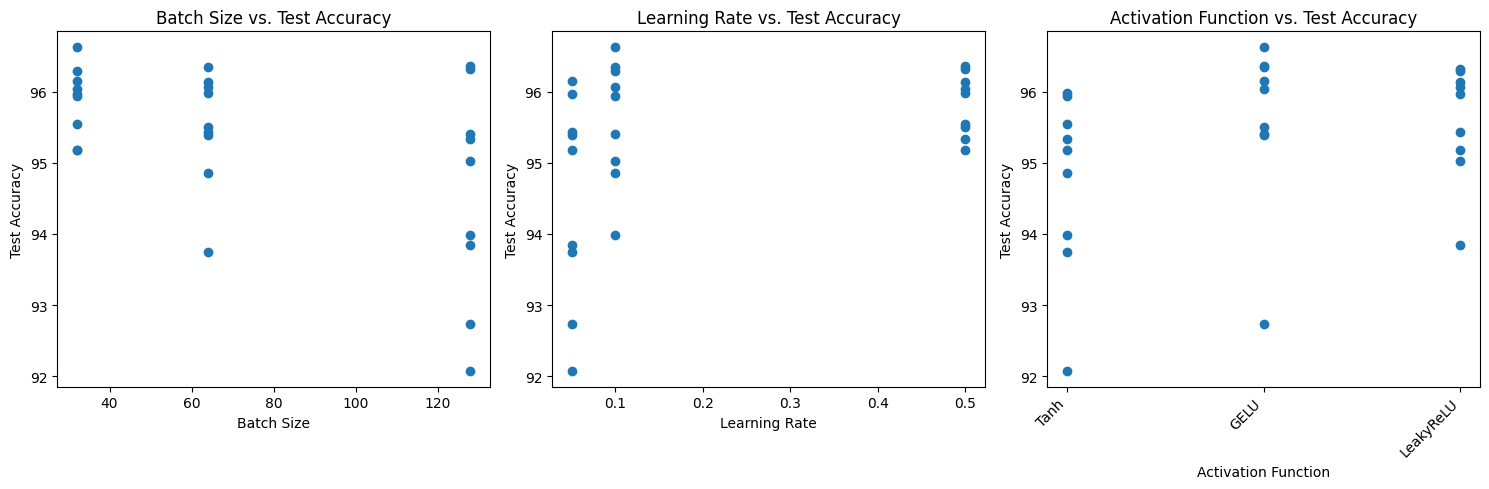

In [16]:
# prompt:  plot batch size, learning rate, and activationn function  vs test accuracy, without connecting the points

import matplotlib.pyplot as plt

# Assuming 'results_df' is your DataFrame from the previous code

plt.figure(figsize=(15, 5))

# Batch size vs. Test Accuracy
plt.subplot(1, 3, 1)
plt.plot(results_df['batch_size'], results_df['test_accuracy'], marker='o', linestyle='None') # linestyle='None' removes connecting lines
plt.xlabel('Batch Size')
plt.ylabel('Test Accuracy')
plt.title('Batch Size vs. Test Accuracy')

# Learning Rate vs. Test Accuracy
plt.subplot(1, 3, 2)
plt.plot(results_df['learning_rate'], results_df['test_accuracy'], marker='o', linestyle='None')
plt.xlabel('Learning Rate')
plt.ylabel('Test Accuracy')
plt.title('Learning Rate vs. Test Accuracy')

# Activation Function vs. Test Accuracy
plt.subplot(1, 3, 3)
plt.plot(results_df['activation'], results_df['test_accuracy'], marker='o', linestyle='None')
plt.xlabel('Activation Function')
plt.ylabel('Test Accuracy')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.title('Activation Function vs. Test Accuracy')

plt.tight_layout()  # Adjust spacing between subplots
plt.show()

What is a learning rate scheduler?

- a learning rate scheduler determines how the learning rate will vary during training.